In [152]:
import pandas as pd
import numpy as np
import regex as re
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

import copy

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from adjustText import adjust_text

import sqlite3
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
import scipy as sp

from tqdm import tqdm
from time import perf_counter

import utils

%matplotlib inline

In [2]:
count_file = 'data/keywords_daily_count.csv'

In [3]:
df = pd.read_csv(count_file)
df = df.convert_dtypes()
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [4]:
sql_db = './data/film_discussions'
conn = sqlite3.connect(sql_db)

In [5]:
t1_start = perf_counter()  

sql = """
    SELECT submissions.title, submissions.created,
    comments.body, comments.author, comments.score,
    topic_scores."Extreme political identities" AS "Pol_identity"
    FROM comments
    INNER JOIN topic_scores ON comments.comment_id = topic_scores.comment_id
    INNER JOIN submissions ON comments.submission_id = submissions.submission_id;
    """

grouped = pd.read_sql(sql, conn)

print(perf_counter()-t1_start)

208.25125960000003


In [113]:
# Group by day
g = grouped.set_index('Date')
g = g.groupby(pd.Grouper(freq='D')).mean()
g.dropna(inplace=True)

In [8]:
# Group by discussion thread
h = grouped.groupby(pd.Grouper('title')).mean()
h.reset_index(inplace=True)
h['Date'] = pd.to_datetime(h['created'], unit='s').dt.date
h = h.set_index('Date')

In [ ]:
topics = pd.read_csv('data/atom_topic_names.csv', sep=';')
pol_names = topics["Name"][topics["Category"] == "Politics"].tolist()

In [111]:
sql = """SELECT submissions.title, submissions.created, comments.body, comments.author, comments.score, """
pol_names_b = []

for i in pol_names:
    k = i.replace(' ', '_')
    k = k.replace(',', '')
    j = f' AVG(topic_scores."{i}") AS "{k}",'
    sql = sql+j
    pol_names_b.append(k)
    
sql = sql[:-1] + """ FROM comments INNER JOIN topic_scores ON comments.comment_id = topic_scores.comment_id INNER JOIN submissions ON comments.submission_id = submissions.submission_id GROUP BY comments.submission_id;"""

In [112]:
t1_start = perf_counter()
grouped = pd.read_sql_query(sql, conn)
print(perf_counter()-t1_start)

11.150260000000344


In [113]:
grouped['Date'] = pd.to_datetime(grouped['created'], unit='s').dt.date
h = grouped.set_index('Date')

In [161]:
g = pd.merge(h, df, left_index=True, right_index=True)

g.drop(["OscarsSoWhite -BLM", "created"], axis=1, inplace=True)

In [162]:
# g = g[(g.index > pd.Timestamp(2014, 1, 1)) & (g.index < pd.Timestamp(2022, 1, 1))]
# Could perhaps also start 2013. 

In [163]:
predictors = ['OscarsSoWhite', 'MeToo', 'BLM']
g[predictors] = g[predictors].astype(int)

In [172]:
pol_names_z = [x+"_z" for x in pol_names_b]
g[pol_names_z] = StandardScaler().fit_transform(g[pol_names_b])

In [89]:
titles = g.title.tolist()

In [90]:
to_remove = [
    "[Spoilers]",
    "[SPOILERS]",
    "Official International Release Discussion:",
    "Official International Release Discussion Thread -",
    "- Official Discussion Thread",
    "Official Discussion Thread:",
    "Discussion Thread.",
    "Official Discussion:",
    "Official Discussion -",
    "Discussion Thread",
    "IMAX re-release",
    "(International Thread)",
    "(Un)Official Discussion:",
    "(US Release)",
    "(International Release)",
    "(UK Release)",
    "(US Thread)",
    "(Thread Vol. 2)",
    "Official Discussion #2 -",
    "Movie Discussion",
    "Un-Official Discussion :",
    "Psuedo-Official Discussion:",
    "(un-Official Discussion)",
    "Official Late-Comer Megathread -",
    "(Roadshow 70mm Cut)",
    "(Theatrical Cut)",
    "The Pre-Official",
    "discussion thread",
    "OFFICIAL DISCUSSION",
    "Official Discussion",
    "[Serious Replies Only]",
    "(Early Release)",
    "(Spoilers inside)",
    "SPOILERS"
]

In [91]:
film_titles = []
for title in titles:
    for j in to_remove:
        title = title.replace(j, "")
        
    title = title.strip()    
    film_titles.append(title)

In [92]:
def adjust_lightness(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], c[1] * amount, c[2])

In [93]:
# Okabe Ito colors
REGION_COLS = ["#7fc97f", "#beaed4", "#fdc086"]
#REGION_COLS = ['#66c2a5','#fc8d62','#8da0cb']
DARK_2 = ['#1b9e77','#d95f02','#7570b3']

# Category values for the colors
CATEGORY_CODES = pd.Categorical(predictors).codes

# Select colors for each region according to its category.
COLORS = np.array(REGION_COLS)[CATEGORY_CODES]
COLORS = REGION_COLS

# Compute colors for the edges: simply darker versions of the original colors
EDGECOLORS = [adjust_lightness(color, 0.6) for color in COLORS]



In [119]:
pol_names_b

['Contrarian_arguing_narrowmindedness',
 'Extreme_political_identities',
 'Forms_of_government',
 'Harassing_raping_and_murdering',
 'Political_and_racial_identities',
 'Political_issues',
 'Social_and_cultural',
 'Wealthy_and_introverted']

In [178]:
g[pol_names_b].mean()

Contrarian_arguing_narrowmindedness    0.003597
Extreme_political_identities           0.001571
Forms_of_government                    0.003185
Harassing_raping_and_murdering         0.001265
Political_and_racial_identities        0.003047
Political_issues                       0.000754
Social_and_cultural                    0.005984
Wealthy_and_introverted                0.000929
dtype: float64

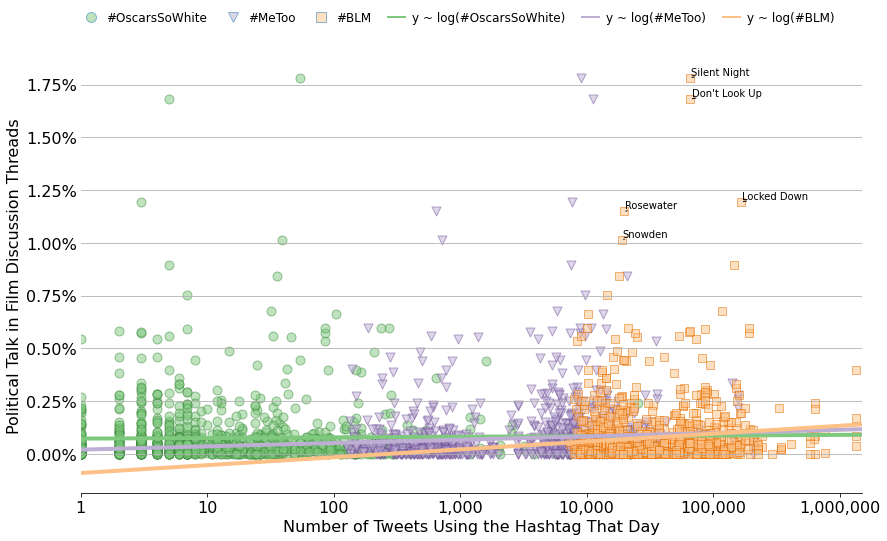

In [193]:
plt.rcParams.update({"font.size": "16"})
markers = ['o', 'v', 's']
predictors = ['OscarsSoWhite', 'MeToo', 'BLM']
dep = "Political_issues"
fig, ax = plt.subplots(figsize=(14,8))

# Add scatterplots -----------------------------------------------------
for idx, name in enumerate(predictors):
    ax.scatter(name, dep, data=g, 
           color=REGION_COLS[idx], edgecolors=EDGECOLORS[idx], s=80, alpha=0.5, zorder=1, marker=markers[idx])

# Customize axes -----------------------------------------------------
# x axis
plt.xscale('log', base=np.e)
plt.xlim(1, 1500000)

ticks = [1,10,100,1000,10000,100000,1000000]
tick_labels = [f'{value:,}' for value in ticks]

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)

# y axis
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1, 2))
ax.yaxis.set_tick_params(length=0)
ax.grid(axis="y")

# Remove all spines but keep the bottom one
ax.spines["left"].set_color("none")
ax.spines["right"].set_color("none")
ax.spines["top"].set_color("none")

# Set labels
ax.set_xlabel("Number of Tweets Using the Hashtag That Day")
ax.set_ylabel("Political Talk in Film Discussion Threads")

# Add regression lines -----------------------------------------------------
for idx, name in enumerate(predictors):
    x = g[name].astype(int).values
    X = x.reshape(-1, 1)
    y = g[dep].values
    linear_regressor = LinearRegression()
    linear_regressor.fit(np.ma.log(X), y)
    x_pred = np.log(np.linspace(1, 1500000, num=200).reshape(-1, 1))
    y_pred = linear_regressor.predict(x_pred)  
    ax.plot(np.exp(x_pred), y_pred, color=REGION_COLS[idx], lw=4)

# Add legend -----------------------------------------------------
handles = [
    Line2D(
        [], [], label="#"+name, 
        lw=0, # there's no line added, just the marker
        marker=markers[idx], # circle marker
        markersize=10, 
        markerfacecolor=REGION_COLS[idx], # marker fill color
    )
    for idx, name in enumerate(predictors)
]

for idx, name in enumerate(predictors):
    handles += [Line2D([], [], label="y ~ log(#"+name+")", color=REGION_COLS[idx], lw=2)]

legend = fig.legend(
    handles=handles,
    bbox_to_anchor=[0.5, 0.95], # Located in the top-mid of the figure.
    fontsize=12,
    handletextpad=0.6, # Space between text and marker/line
    handlelength=1.4, 
    columnspacing=1.4,
    loc="center", 
    ncol=len(handles),
    frameon=False
)

# Set transparency
for idx, name in enumerate(predictors): 
    handle = legend.legendHandles[idx]
    handle._legmarker.set_alpha(0.5)

# Add labels -----------------------------------------------------
#https://stackoverflow.com/questions/19073683/matplotlib-overlapping-annotations-text
texts = []
for idx, pol in enumerate(g[dep]):
    if pol > .01:
        for name in predictors:
            if name == 'BLM':
                x = g[name][idx]
                if x > 0:
                    texts.append(plt.text(x, g[dep][idx], film_titles[idx], fontsize=10))
            
# Adjust text position and add lines -----------------------------
# 'expand_points' is a tuple with two multipliers by which to expand
# the bounding box of texts when repelling them from points

adjust_text(
    texts, 
    arrowprops=dict(arrowstyle="-", lw=1),
    ax=ax
)
    
plt.savefig("output/tweets_poltalk.svg", format='svg', dpi=1200)
plt.show()

## Regression

In [20]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [143]:
pol_names_b

['Contrarian_arguing_narrowmindedness',
 'Extreme_political_identities',
 'Forms_of_government',
 'Harassing_raping_and_murdering',
 'Political_and_racial_identities',
 'Political_issues',
 'Social_and_cultural',
 'Wealthy_and_introverted']

In [237]:
for pred in predictors:
    day = g.loc[g[pred] == g[pred].max()].index[0] + pd.DateOffset(30)
    y = pred+"_peak"
    g[y] = [True if x > day else False for x in g.index]

In [248]:
results = smf.ols('Political_issues_z ~ BLM', data=g).fit()
results = smf.ols('Political_issues_z ~ np.log(BLM)', data=g).fit()

In [249]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     Political_issues_z   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     14.17
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           0.000176
Time:                        13:06:48   Log-Likelihood:                -1638.9
No. Observations:                1160   AIC:                             3282.
Df Residuals:                    1158   BIC:                             3292.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.1949      0.319     -3.748      

In [250]:
results = smf.ols('Political_issues_z ~ np.log(BLM) + BLM_peak', data=g).fit()

In [251]:
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:     Political_issues_z   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.027
Method:                 Least Squares   F-statistic:                     16.82
Date:                Tue, 01 Mar 2022   Prob (F-statistic):           6.28e-08
Time:                        13:07:04   Log-Likelihood:                -1629.3
No. Observations:                1160   AIC:                             3265.
Df Residuals:                    1157   BIC:                             3280.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.0780      0.429  

In [236]:
g.loc[g[pred] == g[pred].max()].index[0] + pd.DateOffset(30)

Timestamp('2020-06-12 00:00:00')